In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

# from scipy.interpolate import BarycentricInterpolator, KroghInterpolator
from scipy.interpolate import RectBivariateSpline


import numpy as np
import time
# from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:3


In [2]:
torch.pi = torch.acos(torch.zeros(1)).item() * 2

def initial_TC(x):
    # T_init = np.array(x<0.5,dtype = 'int')
    # C_init = np.array(x>0.5,dtype = 'int')

    T_init = 0.0*x
    # C_init = 1.0 + 0.0*x
    C_init = np.sin(2*np.pi*x)

    # T_init = np.sin(np.)

    return T_init,C_init

def boundary_TC(x):
    T1 = 0
    T2 = 0
    C1 = 0
    C2 = 0

    return T1,T2,C1,C2

def forcing_func(x):

    return np.sin(2*np.pi*x)

def forcing_func_torch(x):

    return torch.sin(2*torch.pi*x)

In [3]:
t_max = 1
t_steps = 1001

In [4]:
#Code from ChatGPT
# dT/dt = alpha*d^2T/dx^2 + beta*C
# dC/dt = D*d^2T/dx^2 + gamma*C
#T(0,t)=T(L,t)=0,C(0,t)=C(L,t)=0 Boundaries #Sometimes I change
#Initial T(x,0)=f(x),C(x,0)=g(x)

# Parameters
L = 1.0            # Length of the rod
N_x = 200           # Number of cells
dx = L / N_x         # Cell width
alpha = 0.01       # Thermal diffusivity
D = 0.01           # Diffusion coefficient
beta = 1.0         # Coupling coefficient for temperature
gamma = 1.0        # Coupling coefficient for concentration
        
t_end = t_max        # End time
dt =  t_max/(t_steps-1)         # Time step size
x = np.linspace(dx/2, L - dx/2, N_x)  # Cell centers
t = np.linspace(0,t_end,t_steps)

T = []
C =[]
# Time loop

# T.append(np.sin(np.pi*x))  # Initial temperature distribution
# C.append(np.cos(np.pi*x))  # Initial concentration distribution

# T.append(np.ones((N,)))
# C.append(np.ones((N,)))
T_init,C_init = initial_TC(x)
T1,T2,C1,C2 = boundary_TC(x)

T.append(T_init)
C.append(C_init)

f = forcing_func(x)


t = 0.0
time_step = 0

while t < t_end:
    # Compute fluxes
    T_flux = alpha * (np.roll(T[time_step], -1) - 2 * T[time_step] + np.roll(T[time_step], 1)) / dx**2
    C_flux = D * (np.roll(C[time_step], -1) - 2 * C[time_step] + np.roll(C[time_step], 1)) / dx**2

    # Update equations
    T_new = T[time_step] + dt * (T_flux + beta * C[time_step] + f)
    C_new = C[time_step] + dt * (C_flux + gamma * T[time_step])

    # Apply boundary conditions (Dirichlet: T = 0, C = 0 at boundaries)
    T_new[0] = T1
    T_new[-1] = T2
    C_new[0] = C1
    C_new[-1] = C2

    
    errorT = np.sqrt(np.mean(np.square(T[time_step]-T_new)))
    errorC = np.sqrt(np.mean(np.square(C[time_step]-C_new)))


    time_step+= 1

    # Update variables
    T.append(T_new)
    C.append(C_new)
    t += dt

T_FVM = np.transpose(np.array(T))
C_FVM = np.transpose(np.array(C))


T_FVM_norm = np.linalg.norm(T_FVM,2)
C_FVM_norm = np.linalg.norm(C_FVM,2)

In [5]:
loss_thresh = 25000
level = "_low"
label = "Burgers_coPINN_" 

x = np.linspace(0,1,N_x).reshape(-1,1)
t = np.linspace(0,t_max,t_steps).reshape(-1,1)

X,T = np.meshgrid(x,t)

X = X.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xt = np.hstack((X,T))

lb_xt = xt[0]
ub_xt = xt[-1]

In [6]:

pi = torch.from_numpy(np.array(np.pi)).double().to(device)


x = np.linspace(0,1,N_x)
t = np.linspace(0,t_max,t_steps)

X,T = np.meshgrid(x,t)

X = X.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xt = np.hstack((X,T))

xt_test_tensor = torch.from_numpy(xt).float().to(device)


In [7]:
def trainingdata(N_T,N_f,seed):
    '''Boundary Conditions''' 
    
    
    T1,T2,C1,C2 = boundary_TC(x)

    np.random.seed(seed)
    
    x_l = x[0]*np.ones((N_T,1))
    t_l = np.random.uniform(t[0],t[-1],(N_T,1))
    xt_l = np.hstack((x_l,t_l))
    T_l = T1*np.ones((N_T,1))
    C_l = C1*np.ones((N_T,1))
    
    x_r = x[-1]*np.ones((N_T,1))
    t_r = np.random.uniform(t[0],t[-1],(N_T,1))
    xt_r = np.hstack((x_r,t_r))
    T_r = T2*np.ones((N_T,1))
    C_r = C2*np.ones((N_T,1))
    
    
    x_0 = np.random.uniform(x[0],x[-1],(N_T,1))
    t_0 = t[0]*np.ones((N_T,1))
    xt_0 = np.hstack((x_0,t_0))
    T_init,C_init = initial_TC(x_0)
    T_0 = T_init
    C_0 = C_init
    
    xt_BC = np.vstack((xt_l,xt_r,xt_0)) #choose indices from  set 'idx' (x,t)
    T_BC = np.vstack((T_l,T_r,T_0))
    C_BC = np.vstack((C_l,C_r,C_0))
    
    TC_BC = np.hstack((T_BC,C_BC))
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xt_coll = lb_xt + (ub_xt - lb_xt)*samples
    
    xt_coll = np.vstack((xt_coll, xt_BC)) # append training points to collocation points 

    return xt_coll, xt_BC, TC_BC

In [8]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers1,layers2):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears1 = nn.ModuleList([nn.Linear(layers1[i], layers1[i+1]) for i in range(len(layers1)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers1)-1):
            nn.init.xavier_normal_(self.linears1[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears1[i].bias.data)   
        
        beta_mean1 = 1.0*torch.ones((50,len(layers1)-2))
        beta_std1 = 0.1*torch.ones((50,len(layers1)-2))
        
        self.beta1 = Parameter(torch.normal(beta_mean1,beta_std1))
        self.beta1.requiresGrad = True
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears2 = nn.ModuleList([nn.Linear(layers2[i], layers2[i+1]) for i in range(len(layers2)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers2)-1):
            nn.init.xavier_normal_(self.linears2[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears2[i].bias.data)   
        
        beta_mean2 = 1.0*torch.ones((50,len(layers2)-2))
        beta_std2 = 0.1*torch.ones((50,len(layers2)-2))
        
        self.beta2 = Parameter(torch.normal(beta_mean2,beta_std2))
        self.beta2.requiresGrad = True
            
    'foward pass'
    def forward1(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xt).float().to(device)
        lbxy = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xy = 2.0*(xy - lbxy)/(ubxy - lbxy) - 1.0
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers1)-2):
            z = self.linears1[i](a)
            z1 =self.activation(z)
            a = z1 + self.beta1[:,i]*z*z1
       
            
        a = self.linears1[-1](a) 
         
        return a
    
    def forward2(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xt).float().to(device)
        lbxy = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xy = 2.0*(xy - lbxy)/(ubxy - lbxy) - 1.0
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers2)-2):
            z = self.linears2[i](a)
            z1 =self.activation(z)
            a = z1 + self.beta2[:,i]*z*z1
       
            
        a = self.linears2[-1](a) 
         
        return a
                        
    def loss_BC(self,xy,TC):
        
        # uT_pred = self.forward(xy)
        T_pred = self.forward1(xy)
        C_pred = self.forward2(xy)
     
        
        loss_bc_T = self.loss_function(T_pred, TC[:,0].reshape(-1,1))
        loss_bc_C = self.loss_function(C_pred, TC[:,1].reshape(-1,1))
        
        # print(loss_bc_T.cpu().detach().numpy()/loss_bc_u.cpu().detach().numpy())
                
        return loss_bc_T + loss_bc_C
    

    def residuals_f1f2(self, xy_coll):
        
        g = xy_coll.clone()             
        g.requires_grad = True
        # uT = self.forward(g) 
        
        T = self.forward1(g)
        C = self.forward2(g)
        # _times_T = u.detach()*T
        
        T_x_t = autograd.grad(T,g,torch.ones([xy_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        T_xx_tt = autograd.grad(T_x_t,g,torch.ones(xy_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        # dT_dx = T_x_t[:,[0]]
        dT_dt = T_x_t[:,[1]]
        d2T_dx2 = T_xx_tt[:,[0]]
        
        C_x_t = autograd.grad(C,g,torch.ones([xy_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        C_xx_tt = autograd.grad(C_x_t,g,torch.ones(xy_coll.shape).to(device), create_graph=True,allow_unused = True)[0]
        
        # dC_dx = C_x_t[:,[0]]
        dC_dt = C_x_t[:,[1]]
        d2C_dx2 = C_xx_tt[:,[0]]

        # print(dT_dt.shape)
        # print(forcing_func_torch(g[:,0].reshape(-1,1)).shape)
        
        f1 = dT_dt - alpha*d2T_dx2 - beta*C - forcing_func_torch(g[:,0].reshape(-1,1))
        # u = u.detach()    

        
       
        f2 = dC_dt - D*d2C_dx2 - gamma*T

        return f1,f2
        
    
    def loss_PDE(self, xy_coll, f_hat):
       
        f1,f2 = self.residuals_f1f2(xy_coll)
        
        loss_f1 = self.loss_function(f1,f_hat)
        loss_f2 = self.loss_function(f2,f_hat)

        
        
        # print(loss_f2.cpu().detach().numpy()/loss_f1.cpu().detach().numpy())
        # w = loss_f1.cpu().detach().numpy()/loss_f2.cpu().detach().numpy()
                
        return loss_f1 + loss_f2
    
    def loss(self,xy_BC,TC_BC,xy_coll,f_hat):

        loss_BC = self.loss_BC(xy_BC,TC_BC)
        loss_f = self.loss_PDE(xy_coll,f_hat)
        
        loss_val = loss_BC + loss_f
        
        return loss_val
         
    'test neural network'
    def test(self):
        T = self.forward1(xt_test_tensor)
        C = self.forward2(xt_test_tensor)
   
        return T.cpu().detach().numpy(), C.cpu().detach().numpy()

    def test_loss(self):
        T_pred,C_pred = self.test()
        # u_pred = uT_pred[:,0]
        # T_pred = uT_pred[:,1]
        
        # test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_T = np.linalg.norm(T_pred.reshape(-1,1) - T_FVM.reshape(-1,1),2)/T_FVM_norm
        test_re_C = np.linalg.norm(C_pred.reshape(-1,1) - C_FVM.reshape(-1,1),2)/C_FVM_norm
        
        
        return test_re_T, test_re_C 

In [9]:
def data_update(loss_np):
    train_loss.append(loss_np)

    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [10]:
def train_step(xy_BC,uT_BC,xy_coll,f_hat,seed):

    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(xy_BC,uT_BC,xy_coll,f_hat)
        loss.backward()
        #print(loss.cpu().detach().numpy())
        return loss

    optimizer.step(closure)

In [11]:
def train_model(max_iter,rep): 
    print(rep) 
    torch.manual_seed(rep*9)
    start_time = time.time() 
    thresh_flag = 0

    xy_coll_np_array, xy_BC_np_array, uT_BC_np_array = trainingdata(N_T,N_f,rep*22)
        
    xy_coll = torch.from_numpy(xy_coll_np_array).float().to(device)
    xy_BC = torch.from_numpy(xy_BC_np_array).float().to(device)
    uT_BC = torch.from_numpy(uT_BC_np_array).float().to(device)
        
    f_hat = torch.zeros(xy_coll.shape[0],1).to(device)
    

    for i in range(max_iter):
        train_step(xy_BC,uT_BC,xy_coll,f_hat,i)
        loss_np = PINN.loss(xy_BC,uT_BC,xy_coll,f_hat).cpu().detach().numpy()
        
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1          
                thresh_flag = 1       
        data_update(loss_np)
        
        print(i,"Train Loss",train_loss[-1],"RE T:",test_mse_loss[-1],"RE C:",test_re_loss[-1])   
        
    elapsed_time[rep] = time.time() - start_time  
    print('Training time: %.2f' % (elapsed_time[rep]))

In [12]:
max_reps = 1
max_iter = 200 #200

train_loss_full = []
test_mse_full = []
test_re_full = []

elapsed_time= np.zeros((max_reps,1))
time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))



N_T = 2000 #Total number of data points for 'y'
N_f = 10000 #Total number of collocation points 


for reps in range(max_reps):
    print(label)
    print(reps)
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
 
    
    torch.manual_seed(reps*36)
    
    layers1 = np.array([2,50,50,50,50,1]) #9 hidden layers
    layers2 = np.array([2,50,50,50,50,1]) #9 hidden layers

    PINN = Sequentialmodel(layers1,layers2)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                              max_iter = 20, 
                              max_eval = 30, 
                              tolerance_grad = 1e-08, 
                              tolerance_change = 1e-08, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')



   
    
    nan_flag = train_model(max_iter,reps)
    
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    #elapsed_time[reps] = time.time() - start_time



    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full,"test_re_loss": test_re_full,"Time": elapsed_time, "label": label,"Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

Burgers_coPINN_
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears1): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
  (linears2): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 0.19722709 RE T: 0.758431098621975 RE C: 0.9743801963564727
1 Train Loss 0.1089997 RE T: 0.6664997782157637 RE C: 0.733644033791256
2 Train Loss 0.019111626 RE T: 0.10938961678764969 RE C: 0.15196990102007216
3 Train Loss 0.0033897436 RE T: 0.054176140917556216 RE C: 0.054536892109728584
4 Train Loss 0.0012900296 RE T: 0.05552784058099401 RE C: 0.030145003689179738
5 Train Loss 0.0005402527 RE T: 0.05343353525849461 RE C: 0.0258329207383993
6 Train Loss 0.00028001

In [13]:
#CHECKING RESIDUALS AND PLOTTING
#f2 = dC_dt - D*d2C_dx2 - gamma*T

def residuals_fvm(x,t,T_matrix,C_matrix,x_test,t_test):
    T_interpolator = RectBivariateSpline(x,t,T_matrix)
    d2T_dx2_interpolator = T_interpolator.partial_derivative(dx=2,dy = 0)
    dT_dt_interpolator = T_interpolator.partial_derivative(dx=0,dy = 1)

    # T_test = T_interpolator(x_test,t_test)
    dT_dt_test = dT_dt_interpolator(x_test,t_test)
    d2T_dx2_test = d2T_dx2_interpolator(x_test,t_test)

    f = forcing_func(x)

    f1_test =  dT_dt_test - alpha*d2T_dx2_test - beta*C_matrix - f


    C_interpolator = RectBivariateSpline(x,t,C_matrix)
    d2C_dx2_interpolator = C_interpolator.partial_derivative(dx=2,dy = 0)
    dC_dt_interpolator = C_interpolator.partial_derivative(dx=0,dy = 1)

    # C_test = C_interpolator(x_test,t_test)
    dC_dt_test = dC_dt_interpolator(x_test,t_test)
    d2C_dx2_test = d2C_dx2_interpolator(x_test,t_test)


    f2_test =  dC_dt_test - D*d2C_dx2_test - gamma*T_matrix 

    return f1_test,f2_test
    

def res_compare(opt):
    x = np.linspace(0,L,N_x).reshape(-1,1)
    t = np.linspace(0,t_max,t_steps).reshape(-1,1)

    if(opt == 'grid'):
        x_test = x
        t_test = t
    elif(opt == 'neutral'):
        x_test = np.sort(np.random.uniform(L/10,L - L/10,(N_x,)))
        t_test = np.sort(np.random.uniform(t_max/10,t_max - t_max/10,(t_steps,)),axis = 0)
    else:
        print("Give grid or neutral option")
        return 

    x_pinn,t_pinn = np.meshgrid(x_test,t_test)

    x_pinn = x_pinn.flatten('F').reshape(-1,1)
    t_pinn = t_pinn.flatten('F').reshape(-1,1)
    
    xt_pinn_test= np.hstack((x_pinn,t_pinn))
    
    xt_test_tensor = torch.from_numpy(xt_pinn_test).float().to(device)

    # T_PINN = PINN.forward1(xt_test_tensor).cpu().detach().numpy()
    # C_PINN = PINN.forward2(xt_test_tensor).cpu().detach().numpy()

    # T_PINN_matrix = T_PINN.reshape(N_x,t_steps)
    T_FVM_matrix = T_FVM.reshape(N_x,t_steps)

    # C_PINN_matrix = C_PINN.reshape(N_x,t_steps)
    C_FVM_matrix = C_FVM.reshape(N_x,t_steps)

    f1_PINN,f2_PINN = PINN.residuals_f1f2(xt_test_tensor)
    f1_PINN = f1_PINN.reshape(N_x,t_steps).cpu().detach().numpy()
    f2_PINN = f2_PINN.reshape(N_x,t_steps).cpu().detach().numpy()


    f1_fvm,f2_fvm = residuals_fvm(x,t,T_FVM_matrix,C_FVM_matrix,x_test,t_test)


    RMS_Residuals_f1_fvm = np.sqrt(np.mean(np.square(f1_fvm)))
    RMS_Residuals_f1_PINN = np.sqrt(np.mean(np.square(f1_PINN)))


    RMS_Residuals_f2_fvm = np.sqrt(np.mean(np.square(f2_fvm)))
    RMS_Residuals_f2_PINN = np.sqrt(np.mean(np.square(f2_PINN)))

    
    print("PINN_f1: %.4f"%RMS_Residuals_f1_PINN)
    print("FVM_f1: %.4f"%RMS_Residuals_f1_fvm)
    print("PINN_f2: %.4f"%RMS_Residuals_f2_PINN)
    print("FVM_f2: %.4f"%RMS_Residuals_f2_fvm)

    return f1_PINN,f1_fvm,f2_PINN,f2_fvm

In [14]:
#CHECKING RESIDUALS AND PLOTTING ~  GRID POINTS
f1_PINN,f1_FVM,f2_PINN,f2_FVM = res_compare('grid')

PINN_f1: 0.0019
FVM_f1: 0.0069
PINN_f2: 0.0014
FVM_f2: 0.1048


In [27]:
np.mean(f2_FVM)

5.4337797442834806e-15

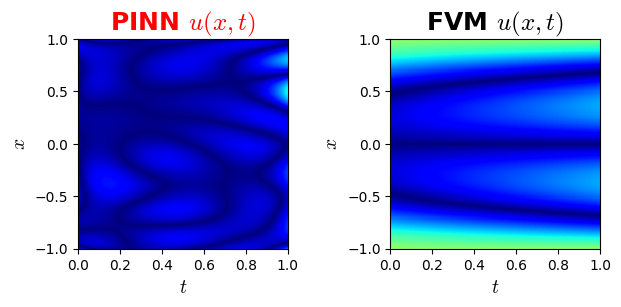

In [20]:
fig, axs = plt.subplots(1,2)
cmap = plt.cm.jet
fig.tight_layout()



ax = axs[0]
img = ax.imshow(np.abs(f1_PINN),interpolation= 'none',cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmin = 0,vmax = 0.03)
ax.set_title('PINN $u(x,t)$',color = 'r',math_fontfamily = 'cm', fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 14)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 14)


ax = axs[1]
img = ax.imshow(np.abs(f1_FVM),interpolation= 'none',cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmin = 0,vmax = 0.03)
ax.set_title('FVM $u(x,t)$',math_fontfamily = 'cm', fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 14)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 14)


fig.tight_layout()
# plt.savefig('Burgers_test_u.svg',format = 'svg')
# plt.savefig('FSU_Burgers_test_u.svg',format = 'svg',bbox_inches = 'tight')

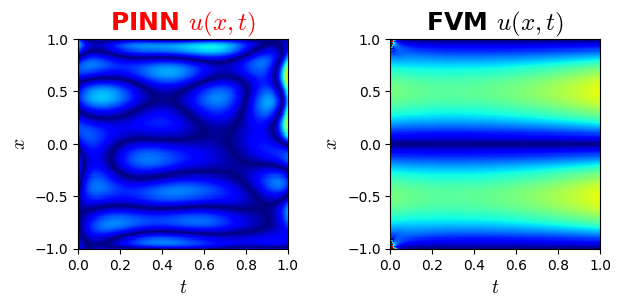

In [31]:
fig, axs = plt.subplots(1,2)
cmap = plt.cm.jet
fig.tight_layout()



ax = axs[0]
img = ax.imshow(np.abs(f2_PINN),interpolation= 'none',cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmin = 0,vmax = 0.01)
ax.set_title('PINN $u(x,t)$',color = 'r',math_fontfamily = 'cm', fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 14)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 14)


ax = axs[1]
img = ax.imshow(np.abs(f2_FVM),interpolation= 'none',cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmin = 0,vmax = 0.01)
ax.set_title('FVM $u(x,t)$',math_fontfamily = 'cm', fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 14)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 14)


fig.tight_layout()

NameError: name 'T_PINN_matrix' is not defined

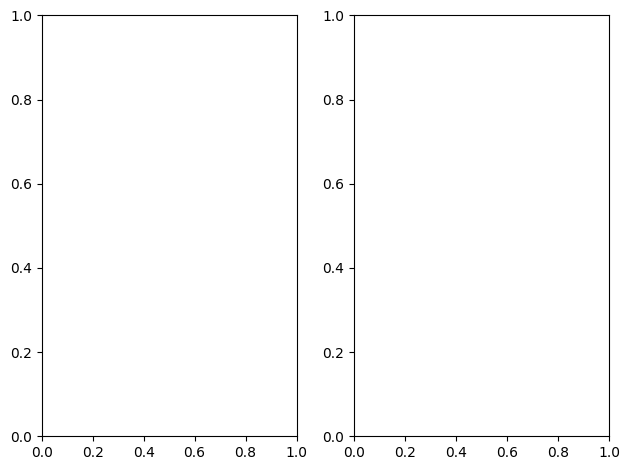

In [16]:
fig, axs = plt.subplots(1,2)
cmap = plt.cm.jet
fig.tight_layout()



ax = axs[0]
img = ax.imshow(T_PINN_matrix,interpolation= 'none',cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmax = 1,vmin = -1)
ax.set_title('PINN $u(x,t)$',color = 'r',math_fontfamily = 'cm', fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 14)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 14)


ax = axs[1]
img = ax.imshow(T_FVM_matrix,interpolation= 'none',cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmax = 1,vmin = -1)
ax.set_title('FVM $u(x,t)$',math_fontfamily = 'cm', fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 14)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 14)


fig.tight_layout()
# plt.savefig('Burgers_test_u.svg',format = 'svg')
# plt.savefig('FSU_Burgers_test_u.svg',format = 'svg',bbox_inches = 'tight')

In [32]:
plt.plot(T_FVM_matrix[:,100],'b')
plt.plot(T_PINN_matrix[:,100],'r')

NameError: name 'T_FVM_matrix' is not defined

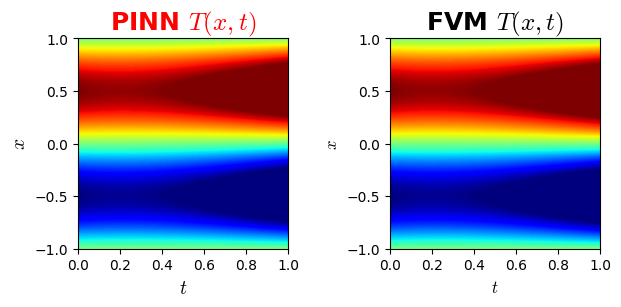

In [81]:
fig, axs = plt.subplots(1,2)
cmap = plt.cm.jet



ax = axs[0]
img = ax.imshow(C_PINN_matrix,cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmax = 1,vmin = -1)
ax.set_title('PINN $T(x,t)$',math_fontfamily = 'cm', color = 'r',fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 14)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 14)
fig.tight_layout()


ax = axs[1]
img = ax.imshow(C_FVM_matrix,cmap = cmap,extent=[0,1,-1,1],aspect = 0.5,vmax = 1,vmin = -1)
ax.set_title('FVM $T(x,t)$',math_fontfamily = 'cm', fontsize = 18,fontweight = 'extra bold')
ax.set_xlabel('$t$',math_fontfamily = 'cm', fontsize = 12)
ax.set_ylabel('$x$',math_fontfamily = 'cm', fontsize = 12)


fig.tight_layout()
# plt.savefig('Burgers_test_T.svg',format = 'svg')
# plt.savefig('FSU_Burgers_test_T.svg',format = 'svg',bbox_inches = 'tight')